In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/MyDrive/SMSstuff/spam.csv'
print(file_path)
import pandas as pd
import numpy as np

Mounted at /content/drive
/content/drive/MyDrive/SMSstuff/spam.csv


In [ ]:
df = pd.read_csv(file_path, encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df.head()


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.columns = ['label', 'message']
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
#get all ham and spam labels and separate them
ham_msg = df[df.label == 'ham']
spam_msg = df[df.label == 'spam']
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())


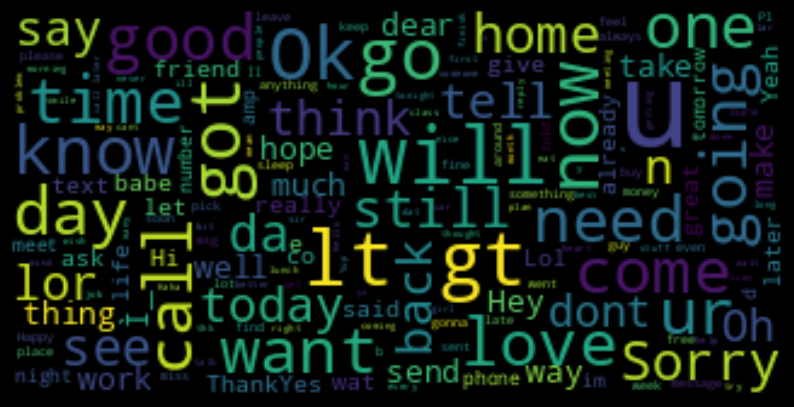

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
ham_msg_cloud = WordCloud(width=320, height=160, stopwords=STOPWORDS, max_font_size=50).generate(ham_msg_text)
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()



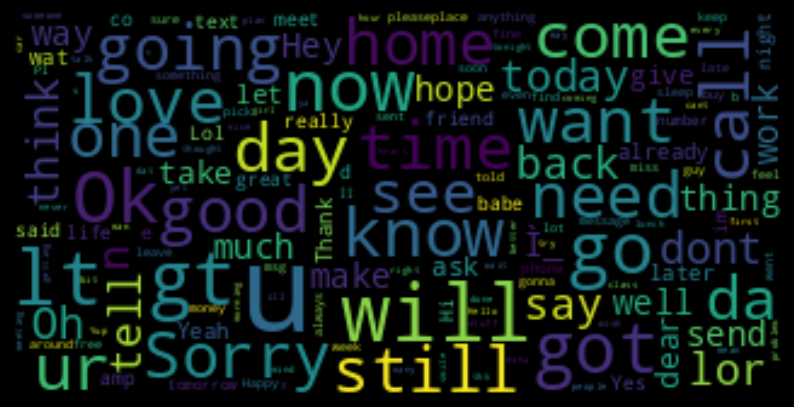

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
spam_msg_cloud = WordCloud(width=320, height=160, stopwords=STOPWORDS, max_font_size=50).generate(ham_msg_text)
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
#find lengths and label the ham vs spam text messages
ham_msg_df = ham_msg.copy()
ham_msg_df['label'] = 0
spam_msg_df = spam_msg.copy()
spam_msg_df['label'] = 1

msg_df = pd.concat([ham_msg_df, spam_msg_df])
msg_df['text_length'] = msg_df['message'].apply(len)
labels = msg_df.groupby('label').mean()
labels



<ipython-input-21-a678f77e1f15>:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  labels = msg_df.groupby('label').mean()


,text_length
label,
0,71.023627
1,138.866131


#Preprocessing the texts

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

#lemmatizer and stop word filtering again
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def preprocess_and_tokenize(text):
  #remove punctuation and make lowercase
  text = text.lower()
  text = text.translate(str.maketrans('', '', string.punctuation))
  #tokenize
  tokens = nltk.word_tokenize(text)
  #remove stop words
  tokenized_text = [word for word in tokens if word not in stop_words]
  #lemmatize
  lemmatized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]

  #join everything back into the string message
  preprocessed_text = ' '.join(lemmatized_text)
  return preprocessed_text






[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df_processed = df.copy()
df_processed['label'] = df['label'].copy()
df_processed['label'][df_processed['label'] == 'ham'] = 0
df_processed['label'][df_processed['label'] == 'spam'] = 1
df_processed['text_length'] = df['message'].apply(len)
df_processed['message'] = df['message'].apply(preprocess_and_tokenize)
df_processed.head()


,label,message,text_length
0,0,go jurong point crazy available bugis n great ...,111
1,0,ok lar joking wif u oni,29
2,1,free entry 2 wkly comp win fa cup final tkts 2...,155
3,0,u dun say early hor u c already say,49
4,0,nah dont think go usf life around though,61


#TF-IDF Vecotorization

##Train Test Split

In [ ]:
X = df_processed['message']
y = df_processed['label']
X.head()
y.head()


0    0
1    0
2    1
3    0
4    0
Name: label, dtype: object

In [ ]:
import random
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)


In [ ]:
import numpy as np
#convert y train to integers
y_train = y_train.to_numpy().astype(int)
type(y_train)
y_test = y_test.to_numpy().astype(int)
type(y_test)




numpy.ndarray

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer with a maximum of 5000 features
tfidf_vect = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf_vect = tfidf_vect.fit_transform(X_train).toarray()
X_train_tfidf_vect




array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_train_tfidf_vect.shape

(3733, 5000)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
# Create a Multinomial Naive Bayes model
text_nb = Pipeline([('tfidf',TfidfVectorizer()),('mnb',MultinomialNB())])

# Fit the model to the training data
text_nb.fit(X_train, y_train)




Pipeline(steps=[('tfidf', TfidfVectorizer()), ('mnb', MultinomialNB())])

#Training the data

In [ ]:
y_preds_mnb=text_nb.predict(X_test)



In [ ]:
#prediction of test data
y_preds_mnb

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
#training score
text_nb.score(X_train,y_train)


0.9742834181623359

In [ ]:
text_nb.score(X_test,y_test)


0.9603045133224578

#Justifications of results

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_preds_mnb)



array([[1587,    0],
       [  73,  179]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_preds_mnb))



              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1587
           1       1.00      0.71      0.83       252

    accuracy                           0.96      1839
   macro avg       0.98      0.86      0.90      1839
weighted avg       0.96      0.96      0.96      1839



#Trying SVC

In [ ]:
from sklearn.svm import SVC

# Create a SVC model
text_svc = Pipeline([('tfidf',TfidfVectorizer()),('svc',SVC())])



In [ ]:
#training
text_svc.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svc', SVC())])

In [ ]:
y_preds_svc=text_svc.predict(X_test)

In [ ]:
y_preds_svc

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
text_svc.score(X_test,y_test)

0.9733550842849374

##Metrics

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_preds_svc))



              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1587
           1       0.99      0.82      0.89       252

    accuracy                           0.97      1839
   macro avg       0.98      0.91      0.94      1839
weighted avg       0.97      0.97      0.97      1839



###Therefore using SVC provides a 97% accuracte prediction model with Language filtering